In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light42_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Mar  9 04:01:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:0A:00.0 Off |                  N/A |
| 37%   52C    P0    59W / 280W |      0MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:42:00.0 Off |                  N/A |
| 62%   

In [3]:
save_dir = 'save/light42_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json   save_15000	save_30000  save_38529	save_5000  save_8986
save_0	    save_20000	save_30857  save_38899	save_7883
save_10000  save_25000	save_35000  save_39726	save_8011


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 39726

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 162.3MiB
TTS size 156.0MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
loaded : 39726
39726
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.018792343139648438


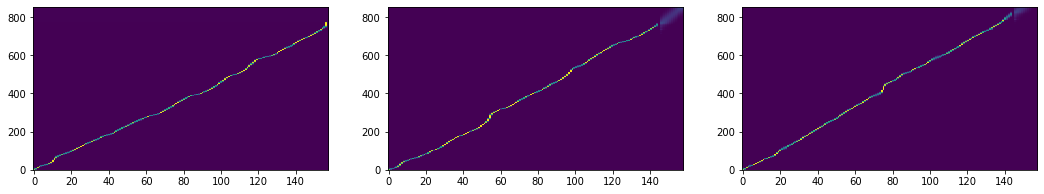

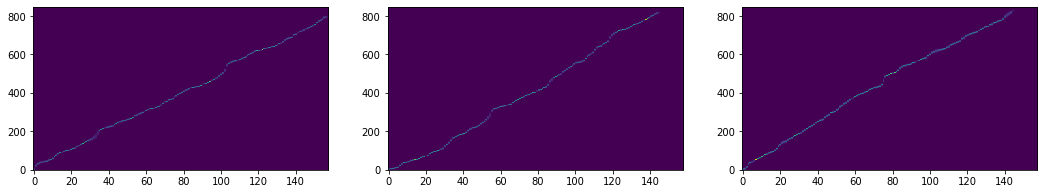

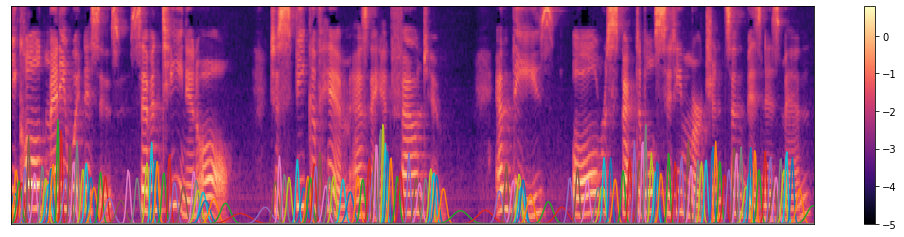

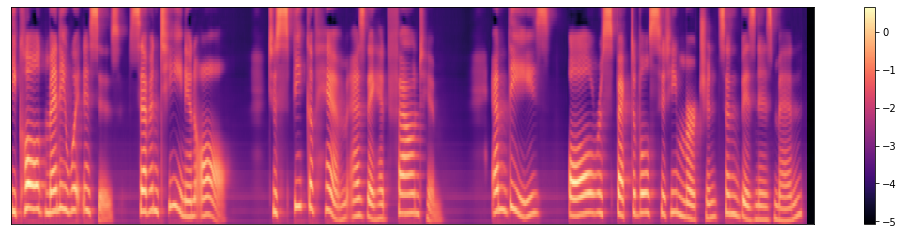

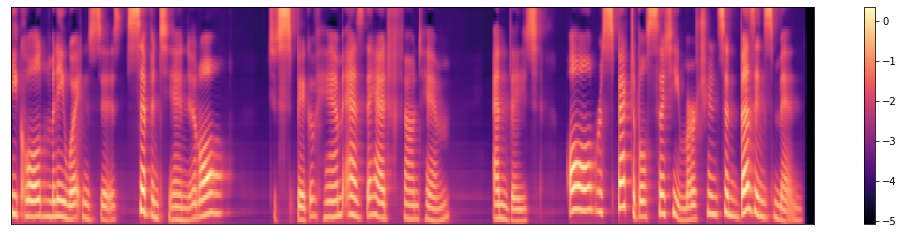

tensor(0.6310, device='cuda:0')
step : 39801 stt : 0.1508 tts : 0.1445 recon : 0.0306 kl : 0.0142 beta : 0.7962
tensor(0.5990, device='cuda:0')
step : 39802 stt : 0.1521 tts : 0.1301 recon : 0.0284 kl : 0.0136 beta : 0.7962
tensor(0.6693, device='cuda:0')
step : 39803 stt : 0.1720 tts : 0.1464 recon : 0.0325 kl : 0.0147 beta : 0.7963
tensor(0.6441, device='cuda:0')
step : 39804 stt : 0.1554 tts : 0.1343 recon : 0.0277 kl : 0.0134 beta : 0.7963
tensor(0.5055, device='cuda:0')
step : 39805 stt : 0.1217 tts : 0.1229 recon : 0.0268 kl : 0.0130 beta : 0.7963
tensor(0.6331, device='cuda:0')
step : 39806 stt : 0.1494 tts : 0.1419 recon : 0.0298 kl : 0.0142 beta : 0.7963
tensor(2.3287, device='cuda:0')
step : 39807 stt : 0.1537 tts : 0.1365 recon : 0.0282 kl : 0.0137 beta : 0.7963
tensor(0.6689, device='cuda:0')
step : 39808 stt : 0.1650 tts : 0.1429 recon : 0.0294 kl : 0.0140 beta : 0.7964
tensor(0.6451, device='cuda:0')
step : 39809 stt : 0.1509 tts : 0.1364 recon : 0.0287 kl : 0.0137 beta :

KeyboardInterrupt: 

In [8]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 4])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 4])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 4])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [9]:
logger.save(step, model, optimizer)

saved save/light42_model/save_39861


In [10]:
batch['text'][0:1]

tensor([[  0, 116, 104,  97, 116,  32, 116, 104, 101,  32,  98,  97, 103,  32,
         119, 104, 105,  99, 104,  32,  79, 115, 119,  97, 108, 100,  32, 119,
          97, 115,  32,  99,  97, 114, 114, 121, 105, 110, 103,  32, 119,  97,
         115,  32,  97, 112, 112, 114, 111, 120, 105, 109,  97, 116, 101, 108,
         121,  32, 116, 119, 101, 110, 116, 121,  45, 115, 101, 118, 101, 110,
          32, 111, 114,  32, 116, 119, 101, 110, 116, 121,  45, 101, 105, 103,
         104, 116,  32, 105, 110,  99, 104, 101, 115,  32, 108, 111, 110, 103,
          44,  32, 119, 104, 101, 114, 101,  97, 115,  32, 116, 104, 101,  32,
         119, 111, 111, 100, 101, 110,  32, 115, 116, 111,  99, 107,  32, 111,
         102,  32, 116, 104, 101,  32, 114, 105, 102, 108, 101,  44,  32, 119,
         104, 105,  99, 104,  32, 105, 115,  32, 105, 116, 115,  32, 108,  97,
         114, 103, 101, 115, 116,  32,  99, 111, 109, 112, 111, 110, 101, 110,
         116,  44]], device='cuda:0')

torch.Size([1, 80, 832]) 0.01228687047958374
{'alignment': 0.0005354881286621094, 'random': 0.0001761913299560547, 'last_conv': 0.0042989253997802734, 'z_proj': 0.0001895427703857422, 'cond': 0.0007121562957763672, 'up': 0.0003521442413330078, 'encode': 0.005116701126098633, 'pad': 4.100799560546875e-05, 'enc_conv': 0.0008747577667236328, 'enc_lstm': 0.00408935546875}


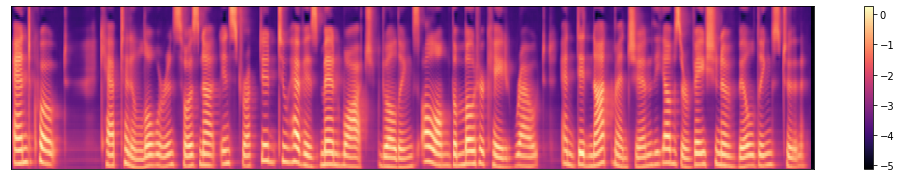

In [11]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(100):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [12]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


alignment 0.03
random 0.01
last_conv 0.26
z_proj 0.01
cond 0.04
up 0.02
encode 0.31
pad 0.00
enc_conv 0.05
enc_lstm 0.25


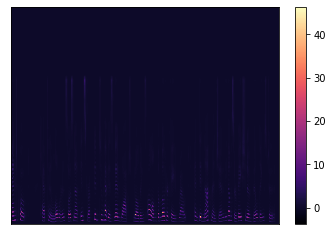

In [13]:
def denormalize(x):
    return 10 ** x

import time

mel_matrix = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
inv_matrix = np.linalg.pinv(mel_matrix)

mel = denormalize(_s[0])
spec = inv_matrix @ mel

librosa.display.specshow(spec)
plt.colorbar()
plt.show()

audio = librosa.griffinlim(spec, n_iter=32, hop_length=256, win_length=None, window='hann')
import IPython.display as ipd
ipd.Audio(audio, rate=22050)